In [1]:
import os
import glob
import itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.signal import chirp, find_peaks, peak_widths


# Define some functions

In [2]:
#function to profess csv file    
#------------------------
# get rid of incorrect neuron and non-target neuron for trace file
#----------------------------------------------------------------------------------
def process_(trace_path, incorrect_neuron_path, position_path):
    
    #read csv
    df = pd.read_csv(trace_path).iloc[1:]
    
    #profecc column in df file
    column_list = df.columns.tolist()
    column_list = [column.strip() for column in column_list]
    column_list[0] = 'Frame'
    df.columns = column_list
    
    # drop the first row, cell-undecide
    #df =df.drop([0])
    
    #read and process incorrect neuron list
    with open(incorrect_neuron_path) as f:
        df_in_list = [line.rstrip('\n') for line in open(incorrect_neuron_path)]
    
    #fix 78 to 078
    new_df_in_list = []
    for i in df_in_list:
        if len(i) < 3:
            sup0 = '0'*(3-len(i))
            i = sup0+i
        new_df_in_list.append(i)
        
    new_df_in_list = ["C" + neuron for neuron in new_df_in_list]
    #print('%i neurons are not correct'%len(new_df_in_list))
    
    # get cells that are not our target
    position = pd.read_csv(position_path, names =['x','y','L'] )
    position['C'] = df.columns[1:]
    position_no = position[(position['L'] == 0)]
    position_no_c_list = position_no['C'].values.tolist()
    #print('%i neurons are not our target'%len(position_no_c_list))

    # merge incorrect neuron list and non-target neuron list
    non_list = list(set(new_df_in_list+position_no_c_list))
    #print('%i neurons are removing'%len(non_list))
    #print(' ')
    # rule out incorrect neurons
    df = df.drop(columns = non_list)


    #convert object dtype to float
    df = df.astype('float')
    
    #set Frame as index
    df = df.set_index('Frame')
    return(df)


#function to sepatate three sessions of one sample
#------------------------

#use separate_session(df)[0/1/2] to get each session
def separate_session(df):
    
    check_point = []

    frame_list = df.index.values.tolist()

    for i in range(len(df)):
        if i < len(df)-1:
            if (frame_list[i+1] - frame_list[i]) > 3:
                check_point.append(frame_list[i+1])


    # separate
    df_0 = df[df.index < check_point[0] ]
    df_1 = df[(df.index < check_point[1]) & (df.index >= check_point[0] ) ]
    df_2 = df[(df.index < check_point[2]) & (df.index >= check_point[1] )]
    df_3 = df[df.index >= check_point[2]]

    return(df_0,df_1,df_2,df_3)


#function to get label array
#------------------------

def process_label(Label_list):
    label = pd.read_csv(Label_list, names = 'Label')
    label = label[['L']]
    label.columns = ['Label']
    labels = label.values
    return(labels)


# process frame list
# event file always start from 10.1s, but some trace frame start from 0, some from 741.19
#----------------------------------------------------------------------------------

def process_frame(df):
    # get frame list
    frame_list = df.index.values.tolist()
    
    for i in frame_list:
        if i != 0:
            a = i-0
        else:
            a = 0
        break
        return(a)
        break

    new_frame_list = [(i-a) for i in frame_list]
    
    return(new_frame_list)

In [3]:
# process event_label list
# event+label starts from 10, but trace start from 0, deduct 10 from event_start&end time
#----------------------------------------------------------------------------------
def process_event_interval(df):
    event_list = df[['From Second','To Second']].values.tolist()
    new_event_list = []
    for event in event_list:
        new_event = [x -10.01 for x in event]
        new_event_list.append(new_event)
    return(new_event_list)


    
# get enevt label for an event file based on different mice and session
# for each session, we have separate event file
#----------------------------------------------------------------------------------
def get_event_label(event_df_0, event_df_1, event_df_2, event_df_3, mice_path):
    
    #get mice
    mice = os.path.basename(mice_path).split('_')[0]    
    # get event status list
    Event_status_0 = event_df_0['Event'].values.tolist()
    Event_status_1 = event_df_1['Event'].values.tolist()
    Event_status_2 = event_df_2['Event'].values.tolist()
    Event_status_3 = event_df_3['Event'].values.tolist()
    Event_status_list = [Event_status_0, Event_status_1, Event_status_2, Event_status_3]
    # compact event label list for three sessions
    event_label_0 = []
    event_label_1 = []
    event_label_2 = []
    event_label_3 = []
    event_label_list = [event_label_0, event_label_1, event_label_2, event_label_3]

    
    if mice in ['NC128', 'NC139', 'NC297', 'NC298', 'NC308', 'NC314', 'NC315', 'NC463', 'NC476',
            'NC102', 'NC103', 'NC114', 'NC296', 'NC313', 'NC462', 'NC464', 'NC468', 'NC475']:
        
        for i in Event_status_0:   
            if i == 'Mouse 1 sniffing On s1':
                event_label_0.append(11)
            elif i == 'Mouse 1 sniffing On s2' :
                event_label_0.append(12)
            elif i == 'Mouse 1 Grooming':
                event_label_0.append(13)

            elif i == 'Area:Mouse 1 Center In Box':
                event_label_0.append(20)
            elif i == 'Area:Mouse 1 Center In Left':
                event_label_0.append(21)
            elif i == 'Area:Mouse 1 Center In Middle':
                event_label_0.append(22)
            elif i == 'Area:Mouse 1 Center In Right':
                event_label_0.append(23)

            elif i == 'Mouse 1 Approaching Area s1':
                event_label_0.append(31)
            elif i ==  'Mouse 1 Approaching Area s2':
                event_label_0.append(32)

            elif i ==  'Area:Mouse 1 Nose In s1':
                event_label_0.append(41)
            elif i ==  'Area:Mouse 1 Nose In s2':
                event_label_0.append(42)
            
            else:
                event_label_0.append(0)
                
                
        for i in Event_status_1:   
            if i == 'Mouse 1 sniffing On s1':
                event_label_1.append(11)
            elif i == 'Mouse 1 sniffing On s2' :
                event_label_1.append(12)
            elif i == 'Mouse 1 Grooming':
                event_label_1.append(13)

            elif i == 'Area:Mouse 1 Center In Box':
                event_label_1.append(20)
            elif i == 'Area:Mouse 1 Center In Left':
                event_label_1.append(21)
            elif i == 'Area:Mouse 1 Center In Middle':
                event_label_1.append(22)
            elif i == 'Area:Mouse 1 Center In Right':
                event_label_1.append(23)

            elif i == 'Mouse 1 Approaching Area s1':
                event_label_1.append(31)
            elif i ==  'Mouse 1 Approaching Area s2':
                event_label_1.append(32)

            elif i ==  'Area:Mouse 1 Nose In s1':
                event_label_1.append(41)
            elif i ==  'Area:Mouse 1 Nose In s2':
                event_label_1.append(42)

            else:
                event_label_1.append(0)

        for i in Event_status_2:  
            if i == 'Mouse 1 sniffing On s1':
                event_label_2.append(12)
            elif i == 'Mouse 1 sniffing On s2' :
                event_label_2.append(11)
            elif i == 'Mouse 1 Grooming':
                event_label_2.append(13)

            elif i == 'Area:Mouse 1 Center In Box':
                event_label_2.append(20)
            elif i == 'Area:Mouse 1 Center In Left':
                event_label_2.append(23)
            elif i == 'Area:Mouse 1 Center In Middle':
                event_label_2.append(22)
            elif i == 'Area:Mouse 1 Center In Right':
                event_label_2.append(21)

            elif i == 'Mouse 1 Approaching Area s1':
                event_label_2.append(32)
            elif i ==  'Mouse 1 Approaching Area s2':
                event_label_2.append(31)

            elif i ==  'Area:Mouse 1 Nose In s1':
                event_label_2.append(42)
            elif i ==  'Area:Mouse 1 Nose In s2':
                event_label_2.append(41)

            else:
                event_label_2.append(0)  
                
        for i in Event_status_3:   
            if i == 'Mouse 1 sniffing On s1':
                event_label_3.append(11)
            elif i == 'Mouse 1 sniffing On s2' :
                event_label_3.append(12)
            elif i == 'Mouse 1 Grooming':
                event_label_3.append(13)

            elif i == 'Area:Mouse 1 Center In Box':
                event_label_3.append(20)
            elif i == 'Area:Mouse 1 Center In Left':
                event_label_3.append(21)
            elif i == 'Area:Mouse 1 Center In Middle':
                event_label_3.append(22)
            elif i == 'Area:Mouse 1 Center In Right':
                event_label_3.append(23)

            elif i == 'Mouse 1 Approaching Area s1':
                event_label_3.append(31)
            elif i ==  'Mouse 1 Approaching Area s2':
                event_label_3.append(32)

            elif i ==  'Area:Mouse 1 Nose In s1':
                event_label_3.append(41)
            elif i ==  'Area:Mouse 1 Nose In s2':
                event_label_3.append(42)

            else:
                event_label_3.append(0)
    
    #if other mice, just the opposite situation
    else:
        
        for i in Event_status_0:   
            if i == 'Mouse 1 sniffing On s1':
                event_label_0.append(11)
            elif i == 'Mouse 1 sniffing On s2' :
                event_label_0.append(12)
            elif i == 'Mouse 1 Grooming':
                event_label_0.append(13)

            elif i == 'Area:Mouse 1 Center In Box':
                event_label_0.append(20)
            elif i == 'Area:Mouse 1 Center In Left':
                event_label_0.append(21)
            elif i == 'Area:Mouse 1 Center In Middle':
                event_label_0.append(22)
            elif i == 'Area:Mouse 1 Center In Right':
                event_label_0.append(23)

            elif i == 'Mouse 1 Approaching Area s1':
                event_label_0.append(31)
            elif i ==  'Mouse 1 Approaching Area s2':
                event_label_0.append(32)

            elif i ==  'Area:Mouse 1 Nose In s1':
                event_label_0.append(41)
            elif i ==  'Area:Mouse 1 Nose In s2':
                event_label_0.append(42)
            
            else:
                event_label_0.append(0)
                
        for i in Event_status_2:   
            if i == 'Mouse 1 sniffing On s1':
                event_label_2.append(11)
            elif i == 'Mouse 1 sniffing On s2' :
                event_label_2.append(12)
            elif i == 'Mouse 1 Grooming':
                event_label_2.append(13)

            elif i == 'Area:Mouse 1 Center In Box':
                event_label_2.append(20)
            elif i == 'Area:Mouse 1 Center In Left':
                event_label_2.append(21)
            elif i == 'Area:Mouse 1 Center In Middle':
                event_label_2.append(22)
            elif i == 'Area:Mouse 1 Center In Right':
                event_label_2.append(23)

            elif i == 'Mouse 1 Approaching Area s1':
                event_label_2.append(31)
            elif i ==  'Mouse 1 Approaching Area s2':
                event_label_2.append(32)

            elif i ==  'Area:Mouse 1 Nose In s1':
                event_label_2.append(41)
            elif i ==  'Area:Mouse 1 Nose In s2':
                event_label_2.append(42)

            else:
                event_label_2.append(0)
                    
        for i in Event_status_1:  
            if i == 'Mouse 1 sniffing On s1':
                event_label_1.append(12)
            elif i == 'Mouse 1 sniffing On s2' :
                event_label_1.append(11)
            elif i == 'Mouse 1 Grooming':
                event_label_1.append(13)

            elif i == 'Area:Mouse 1 Center In Box':
                event_label_1.append(20)
            elif i == 'Area:Mouse 1 Center In Left':
                event_label_1.append(23)
            elif i == 'Area:Mouse 1 Center In Middle':
                event_label_1.append(22)
            elif i == 'Area:Mouse 1 Center In Right':
                event_label_1.append(21)

            elif i == 'Mouse 1 Approaching Area s1':
                event_label_1.append(32)
            elif i ==  'Mouse 1 Approaching Area s2':
                event_label_1.append(31)

            elif i ==  'Area:Mouse 1 Nose In s1':
                event_label_1.append(42)
            elif i ==  'Area:Mouse 1 Nose In s2':
                event_label_1.append(41)

            else:
                event_label_1.append(0) 


        for i in Event_status_3:  
            if i == 'Mouse 1 sniffing On s1':
                event_label_3.append(12)
            elif i == 'Mouse 1 sniffing On s2' :
                event_label_3.append(11)
            elif i == 'Mouse 1 Grooming':
                event_label_3.append(13)

            elif i == 'Area:Mouse 1 Center In Box':
                event_label_3.append(20)
            elif i == 'Area:Mouse 1 Center In Left':
                event_label_3.append(23)
            elif i == 'Area:Mouse 1 Center In Middle':
                event_label_3.append(22)
            elif i == 'Area:Mouse 1 Center In Right':
                event_label_3.append(21)

            elif i == 'Mouse 1 Approaching Area s1':
                event_label_3.append(32)
            elif i ==  'Mouse 1 Approaching Area s2':
                event_label_3.append(31)

            elif i ==  'Area:Mouse 1 Nose In s1':
                event_label_3.append(42)
            elif i ==  'Area:Mouse 1 Nose In s2':
                event_label_3.append(41)

            else:
                event_label_3.append(0)
                
    return(event_label_0, event_label_1, event_label_2, event_label_3)
    
    
# process events file, add event label for string label
#----------------------------------------------------------------------------------
def add_event_label(trace_df, event_0_path, event_1_path, event_2_path, event_3_path, mice_path):
       
    # get separate sessions
    df_0,df_1,df_2,df_3 = separate_session(trace_df)
    # get df1, df2, df3 frame time list
    frame_list_0 = process_frame(df_0)
    frame_list_1 = process_frame(df_1)
    frame_list_2 = process_frame(df_2)
    frame_list_3 = process_frame(df_3)
    #get event dataframe
    event_df_0 = pd.read_excel(event_0_path, skiprows = 6)
    event_df_1 = pd.read_excel(event_1_path, skiprows = 6)
    event_df_2 = pd.read_excel(event_2_path, skiprows = 6)
    event_df_3 = pd.read_excel(event_3_path, skiprows = 6)
    # get event intervals
    interval_list_0 = process_event_interval(event_df_0)
    interval_list_1 = process_event_interval(event_df_1)
    interval_list_2 = process_event_interval(event_df_2)
    interval_list_3 = process_event_interval(event_df_3)
    # get event label
    event_label_0, event_label_1, event_label_2, event_label_3 = get_event_label(event_df_0,
                                                                                 event_df_1, event_df_2, event_df_3, mice_path)

    
    # deal with session 0
    frame_label_list_0 = []
    for frame in frame_list_0:
        frame_label = str()
        if frame > 5:
            #begin to define frame label
            for i in range(len(interval_list_0)):
                if min(interval_list_0[i])  <= frame <= max(interval_list_0[i]) :
                    frame_label = frame_label+ str(event_label_0[i])

        # convert str to int
        if len(frame_label) == 0:
            frame_label = np.nan
        else:
            frame_label = int(frame_label)

        # append frame label to list
        frame_label_list_0.append(frame_label)
            
    # add label list to trace df 
    new_df_0 = df_0
    new_df_0['Frame_Label']  =  frame_label_list_0
    new_df_0 = new_df_0.dropna()
    
    
    # deal with session 1
    frame_label_list_1 = []
    for frame in frame_list_1:
        frame_label = str()
        if frame > 5:
            #begin to define frame label
            for i in range(len(interval_list_1)):
                if min(interval_list_1[i])  <= frame <= max(interval_list_1[i]) :
                    frame_label = frame_label+ str(event_label_1[i])

        # convert str to int
        if len(frame_label) == 0:
            frame_label = np.nan
        else:
            frame_label = int(frame_label)

        # append frame label to list
        frame_label_list_1.append(frame_label)
            
    # add label list to trace df 
    new_df_1 = df_1
    new_df_1['Frame_Label']  =  frame_label_list_1
    new_df_1 = new_df_1.dropna()
        
    # deal with session 2
    frame_label_list_2 = []
    for frame in frame_list_2:
        frame_label = str()
        #begin to define frame label
        for i in range(len(interval_list_2)):
            if min(interval_list_2[i])  < frame < max(interval_list_2[i]) :
                frame_label = frame_label+ str(event_label_2[i])

        # convert str to int
        if len(frame_label) == 0:
            frame_label = np.nan
        else:
            frame_label = int(frame_label)

        # append frame label to list
        frame_label_list_2.append(frame_label)
            
    # add label list to trace df 
    new_df_2 = df_2
    new_df_2['Frame_Label']  =  frame_label_list_2
    new_df_2 = new_df_2.dropna()
        
        
    # deal with session 3
    frame_label_list_3 = []
    for frame in frame_list_3:
        frame_label = str()
        #begin to define frame label
        for i in range(len(interval_list_3)):
            if min(interval_list_3[i])  < frame < max(interval_list_3[i]) :
                frame_label = frame_label+ str(event_label_3[i])

        # convert str to int
        if len(frame_label) == 0:
            frame_label = np.nan
        else:
            frame_label = int(frame_label)

        # append frame label to list
        frame_label_list_3.append(frame_label)
            
    # add label list to trace df 
    new_df_3 = df_3
    new_df_3['Frame_Label']  =  frame_label_list_3
    new_df_3 = new_df_3.dropna()
        
    
    frames = [new_df_0, new_df_1, new_df_2, new_df_3]
    new_df = pd.concat(frames)
    
    #print('The df shape of session 0:',new_df_0.shape)
    #print('The df shape of session 1:',new_df_1.shape)
    #print('The df shape of session 2:',new_df_2.shape)
    #print('The df shape of session 3:',new_df_3.shape)
    #print(' ')
    
    return(new_df, new_df_0, new_df_1, new_df_2, new_df_3)

In [4]:
# to keep certain status frrame interval
#----------------------------------------------------------------------------------
def check_frame_interval(df, which_status_to_check_frame):
    
    # set up which_status_to_check_frame
    
    if which_status_to_check_frame == 'social':
        which_status_to_check_frame = str(11)
    elif which_status_to_check_frame == 'obj':
        which_status_to_check_frame = str(12)
    elif which_status_to_check_frame == 'grooming':
        which_status_to_check_frame = str(13)
    elif which_status_to_check_frame == 'social_zone':
        which_status_to_check_frame = str(21)
    elif which_status_to_check_frame == 'middle_zone':
        which_status_to_check_frame = str(22)
    elif which_status_to_check_frame == 'obj_zone':
        which_status_to_check_frame = str(23)
    else:
        raise ValueError('Not approved status. choose from: social, obj, social_zone, middle_zone, obj_zone, grooming')

    #df = add_event_label(df, event_1_path, event_2_path, event_3_path, mice_path)[which_session]
    frame_label_list = df['Frame_Label'].values.tolist()
    
    # to separate status label, eg:20214111
    n = 2
    
    check_frame_label_list = []
    for line in frame_label_list:
        line = str(line)
        line_list= [line[i:i+n] for i in range(0, len(line), n)]
        if which_status_to_check_frame in line_list:
            check_frame_label_list.append(1)
        else:
            check_frame_label_list.append(0)       
            
    
            
    df['status'] = check_frame_label_list
    df_keep = df[ (df['status'] == 1)]
    df_keep = df_keep.drop('status', axis = 1)
    df_keep = df_keep.drop('Frame_Label', axis = 1)
    
    #print('the shape of the dataframe in the status is:', df_keep.shape)
    return(df_keep)

In [5]:
#function to get corr between each two cell of a dataframe
#----------------------------------------------------------------------------------

def corr_list(df):
    end_range = df.shape[1]
    corr_list = []
    
    if df.shape[0] >2:
        for i in range(end_range):
            a = i+1
            for a in range(a,end_range):
                corr, _ = pearsonr(df.iloc[:,i], df.iloc[:,a])
                corr_list.append(corr)
    return(corr_list)

In [6]:
# Overlay 2 histograms to compare them
#------------------------
def overlaid_histogram(figsize,data1, data2, n_bins = 0, data1_name="", data1_color="#539caf", 
                       data2_name="", data2_color="#7663b0", x_label="", y_label="", title="",
                       y_limit=None,x_limit = None):
    # Set the bounds for the bins so that the two distributions are fairly compared
    max_nbins = 10
    data_range = [min(min(data1), min(data2)), max(max(data1), max(data2))]
    binwidth = (data_range[1] - data_range[0]) / max_nbins


    if n_bins == 0:
        bins = np.arange(data_range[0], data_range[1] + binwidth, binwidth)
    else: 
        bins = n_bins
        
    weights1 = np.ones_like(data1)/float(len(data1))
    weights2 = np.ones_like(data2)/float(len(data2))

    # Create the plot
    _, ax = plt.subplots(figsize = figsize)
    ax.hist(data1, bins = bins, color = data1_color, alpha = 1, 
            label = data1_name, weights=weights1)
    ax.hist(data2, bins = bins, color = data2_color, alpha = 0.75, 
            label = data2_name ,weights=weights2)
    
    if y_limit:
        ax.set_ylim(0, y_limit)
    if x_limit:
        ax.set_xlim(-x_limit, x_limit)
    
    # https://stackoverflow.com/questions/925024/how-can-i-remove-the-top-and-right-axis-in-matplotlib
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html
    # https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/fonts_demo.html
    ax.tick_params(axis='both', which='major', labelsize=20)
    labels = ax.get_yticklabels()
    [label.set_fontname('Arial') for label in labels]
    labels = ax.get_xticklabels()
    [label.set_fontname('Arial') for label in labels]
    #ax.set_ylabel(y_label,fontname="Arial",fontsize = 20)
    #ax.set_xlabel(x_label,fontname="Arial",fontsize = 20)
    #ax.set_title(title, fontsize = 16, fontweight = 'bold')
    #ax.legend(loc = 'best')
    
    plt.savefig(title)


#function to calculate FWHM
#------------------------
def FWHM(distribute):
    
    # calculate sigma and mu for best fit
    sigma = np.nanstd(distribute) # standard deviation of distribution
    mu = np.nanmean(distribute) # mean of the distribution
    
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(distribute, bins=100, density=1)
    
    # generate best fit curve for the histgram
    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *np.exp(-0.5 * (1 / sigma * (bins - mu))**2))

    # calculate FWHM 
    peaks, _ = find_peaks(y)
    results_half = peak_widths(y, peaks, rel_height=0.5)
    FWHM = results_half[0]
    
    plt.close()
    
    return(FWHM)

# Get all samples

In [7]:
# define root path, WT list and Null list
# all with frame = 15
root_path = r'D:\zekai_chen\Mini_Scope\Processed data\Social'
root_path_onoff = r'C:\Users\xiaoqian10\Desktop\XiaoqianSun\Social\ONOFF_Summary'
root_path_incorrect =  r'D:\zekai_chen\Mini_Scope\Processed data\Social\Incorrect neuron number'

WT_list = ['NC128_WT', 
           'NC139_WT', 'NC158_WT', 'NC166_WT', 'NC228_WT',
           'NC230_WT', 'NC238_WT', 'NC297_WT', 'NC298_WT', 
           'NC308_WT', 'NC314_WT', 'NC315_WT', 'NC326_WT', 'NC463_WT', 'NC476_WT']

WT_incorrect_neuron_list = ['NC128_WT.txt',
                            'NC139_WT.txt', 'NC158_WT.txt', 'NC166_WT.txt', 'NC228_WT.txt', 
                            'NC230_WT.txt', 'NC238_WT.txt', 'NC297_WT.txt', 'NC298_WT.txt', 
                            'NC308_WT.txt', 'NC314_WT.txt', 'NC315_WT.txt', 'NC326_WT.txt', 'NC463_WT.txt', 'NC476_WT.txt']


#-----------------------------------------------------------------------------------------------

NULL_list = ['NC102_Null', 'NC103_Null', 
             'NC114_Null', #'NC149_Null', 
             'NC159_Null', 'NC227_Null',
             'NC232_Null', 'NC239_Null', 'NC296_Null', 'NC303_Null', 
             'NC304_Null', 'NC313_Null', 'NC462_Null', 'NC468_Null','NC475_Null']

NULL_incorrect_neuron_list = ['NC102_NULL.txt', 'NC103_NULL.txt',
                              'NC114_NULL.txt', #'NC149_NULL.txt', 
                              'NC159_NULL.txt', 'NC227_NULL.txt', 
                              'NC232_NULL.txt', 'NC239_NULL.txt', 'NC296_NULL.txt','NC303_NULL.txt', 
                              'NC304_NULL.txt', 'NC313_NULL.txt', 'NC462_NULL.txt', 'NC468_NULL.txt','NC475_NULL.txt']



# Call

- individual mouse
- save all mouse corr chain

WT
Processing NC128_WT


C:\Users\xiaoqian10\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:333: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\xiaoqian10\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\xiaoqian10\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:381: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

Processing NC139_WT
Processing NC158_WT
Processing NC166_WT
Processing NC228_WT
Processing NC230_WT


C:\Users\xiaoqian10\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\xiaoqian10\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Processing NC238_WT
Processing NC297_WT
Processing NC298_WT
Processing NC308_WT
Processing NC314_WT
Processing NC315_WT
Processing NC326_WT
Processing NC463_WT


C:\Users\xiaoqian10\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Processing NC476_WT


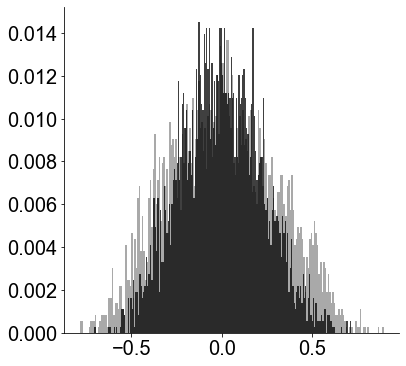

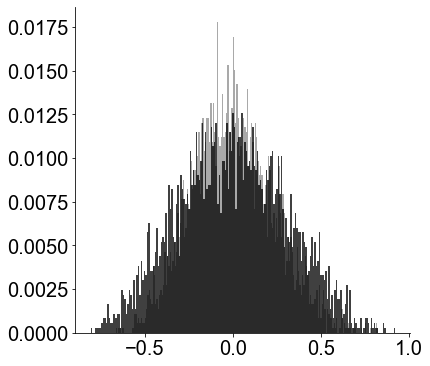

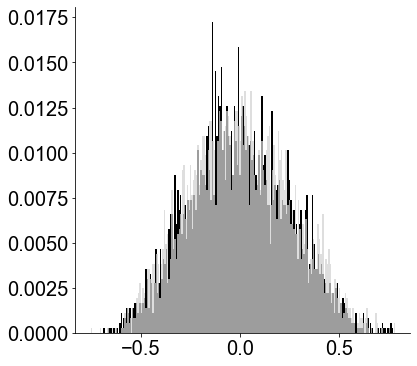

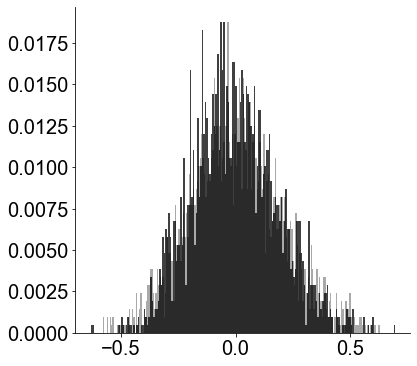

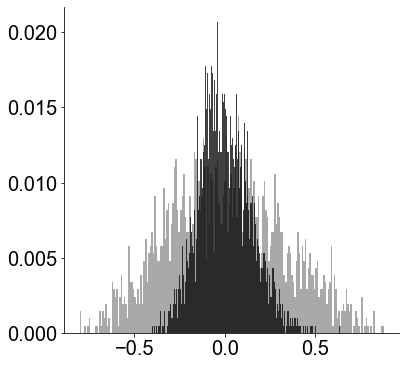

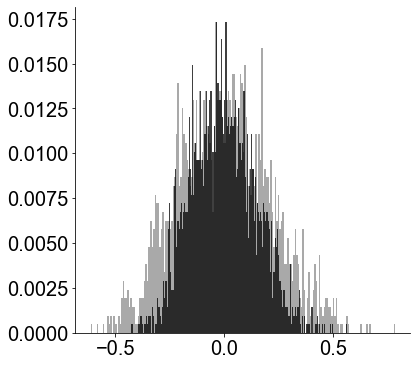

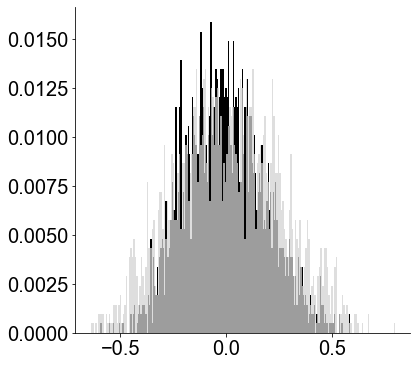

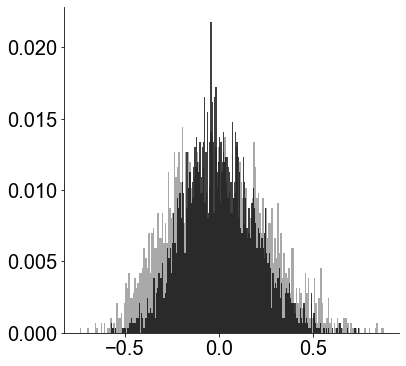

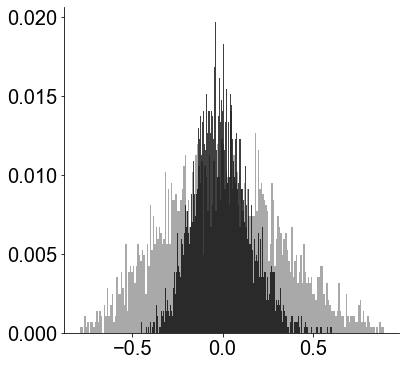

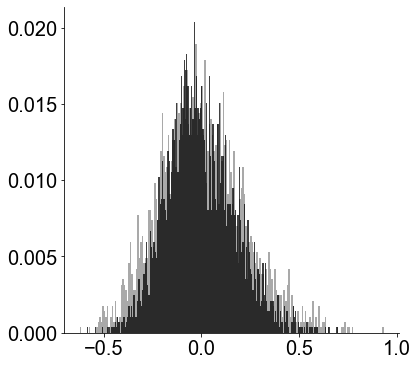

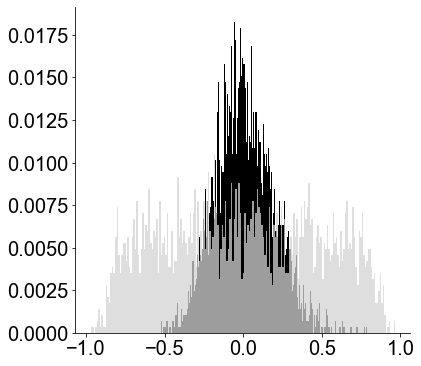

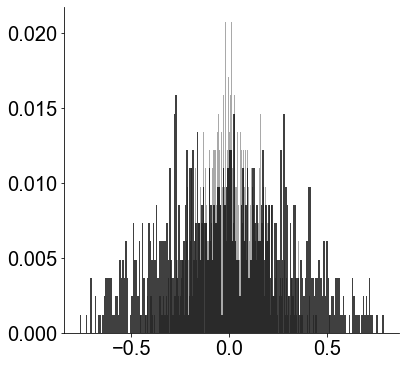

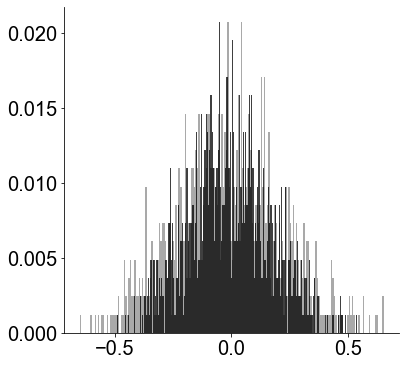

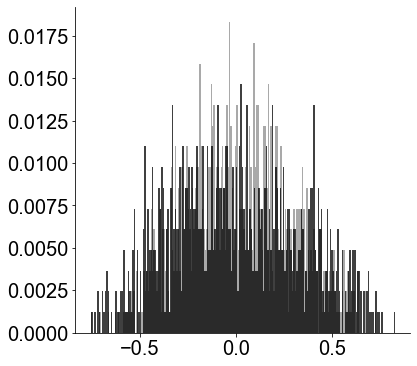

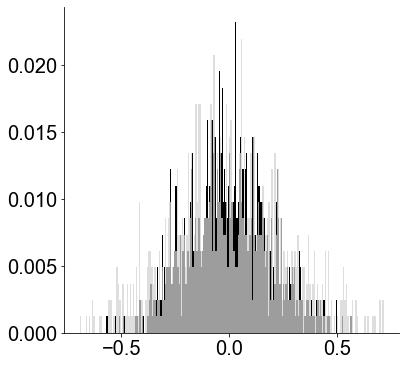

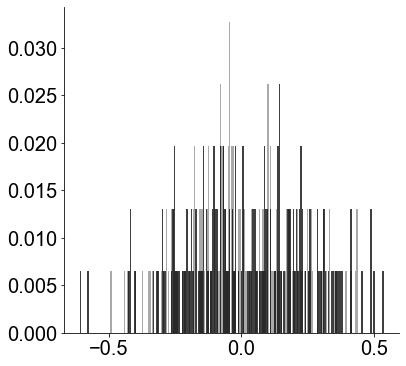

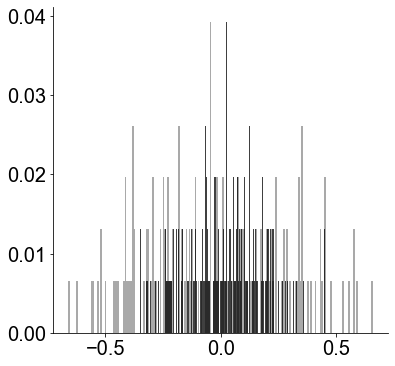

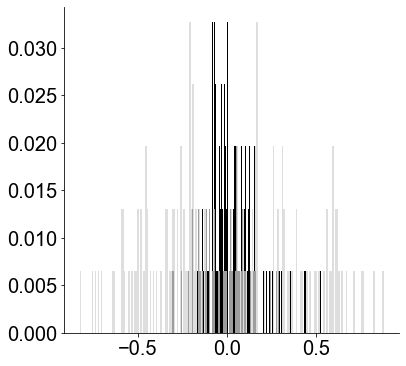

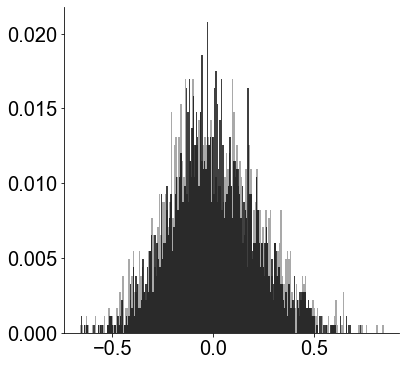

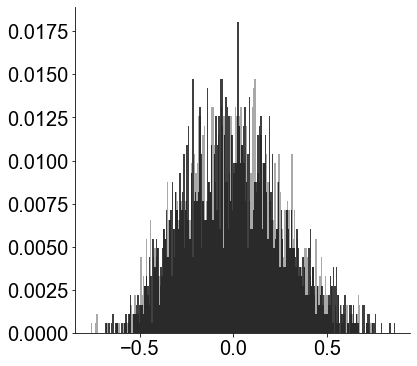

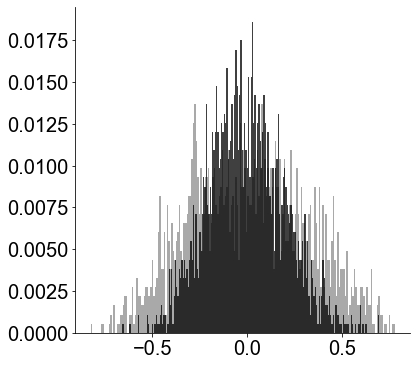

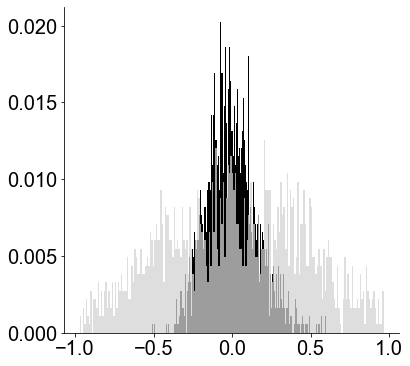

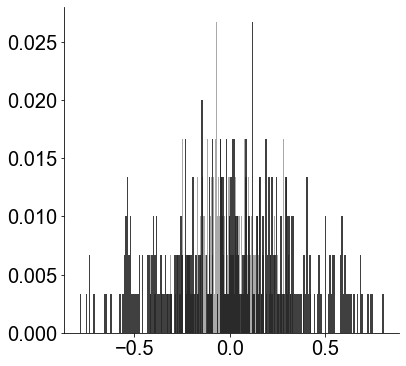

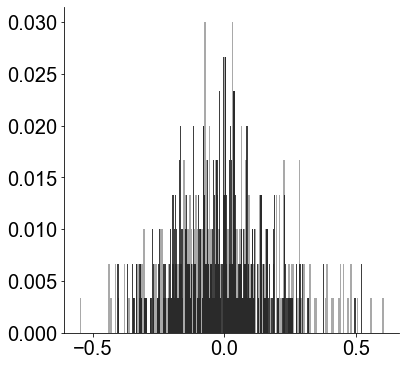

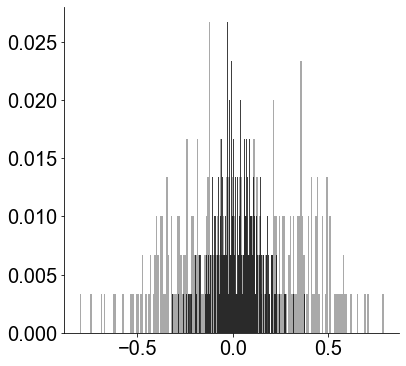

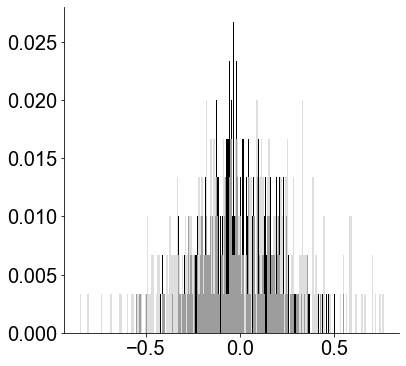

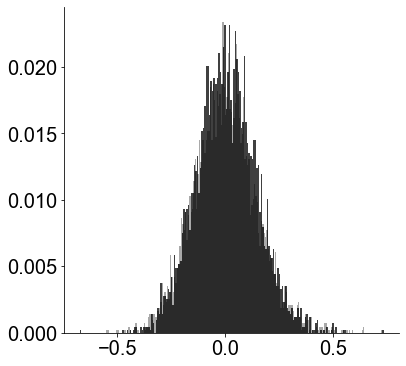

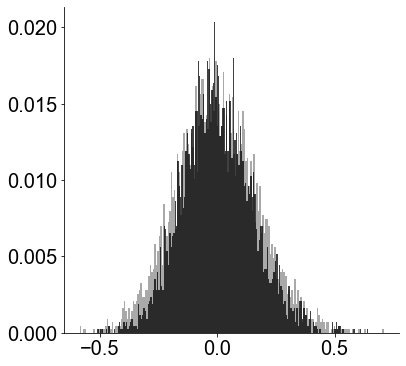

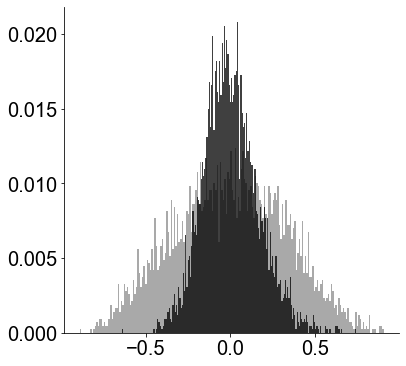

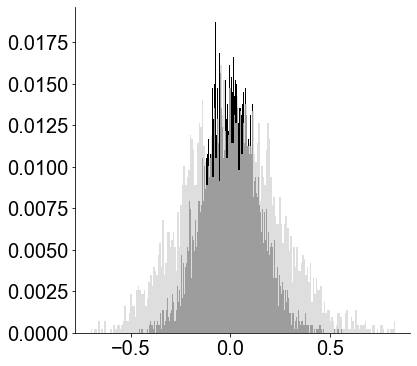

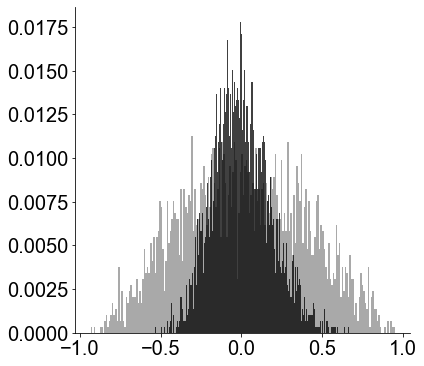

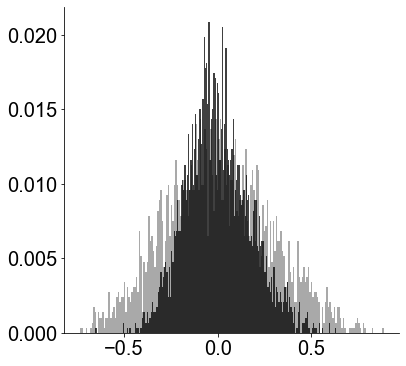

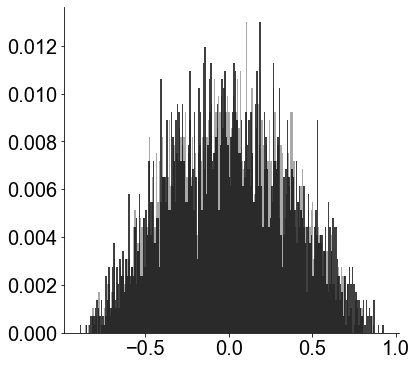

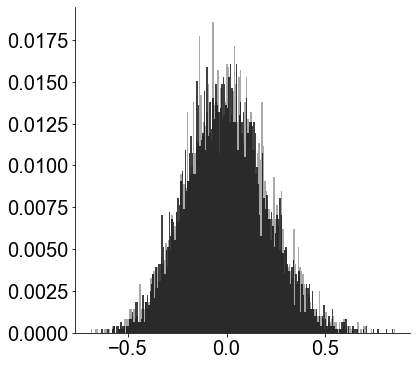

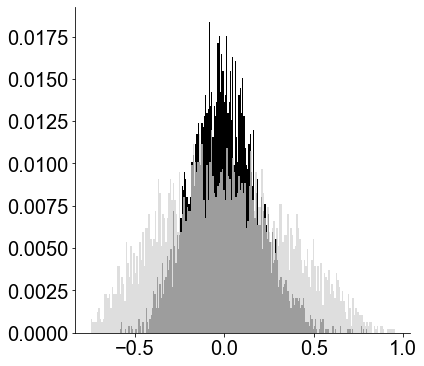

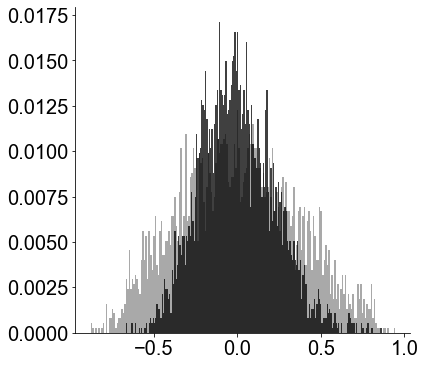

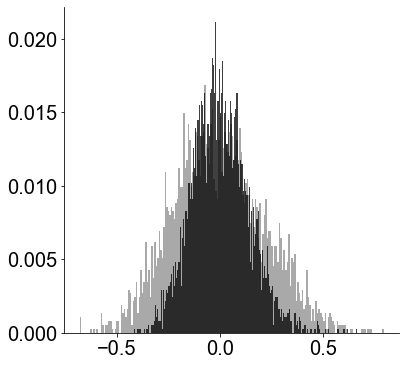

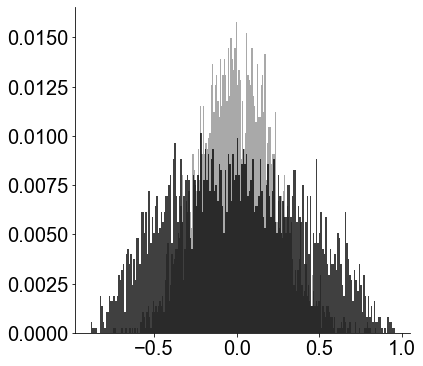

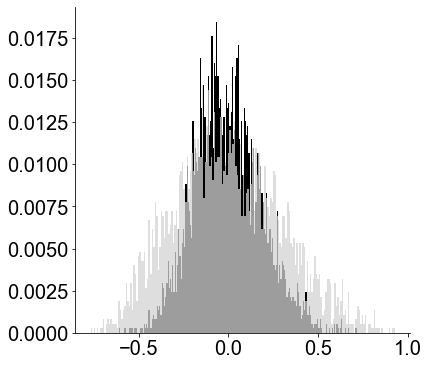

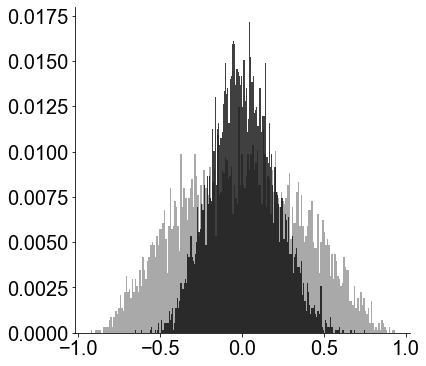

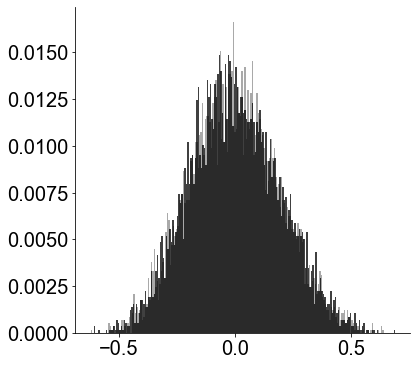

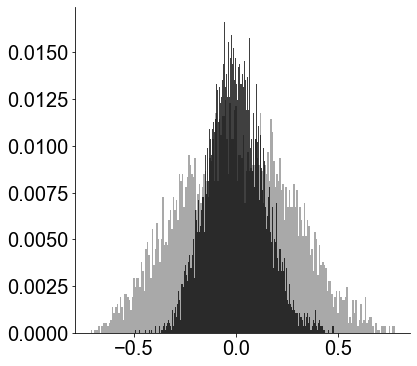

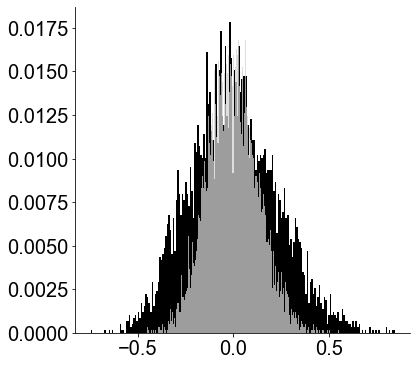

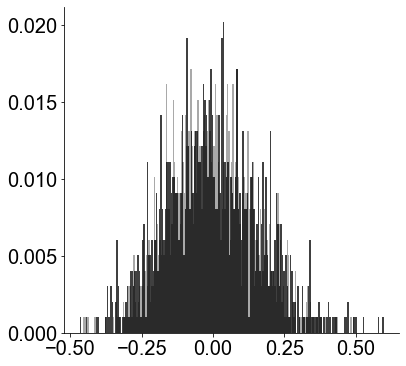

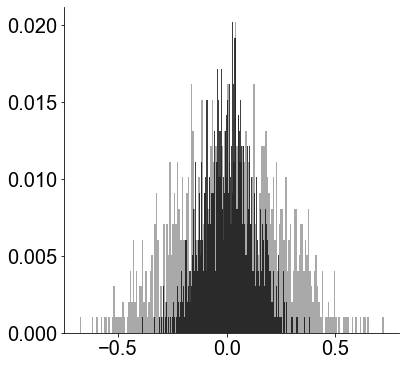

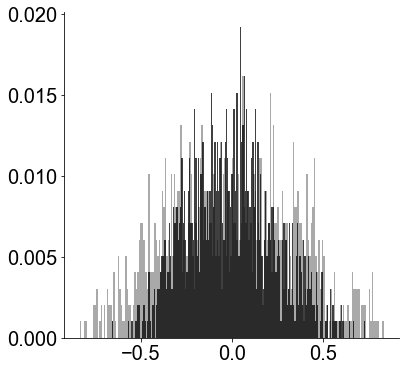

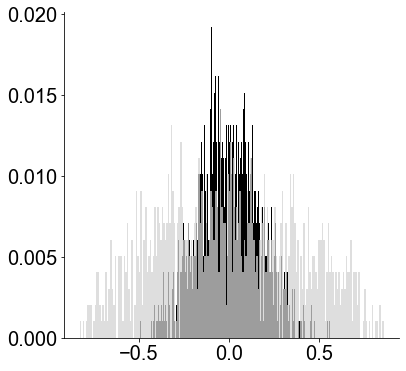

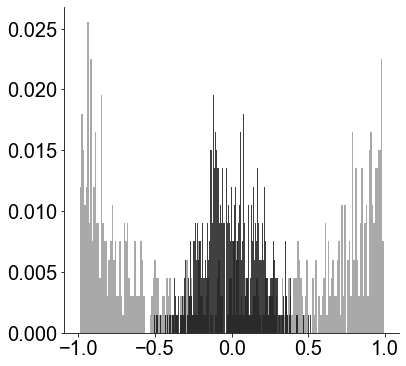

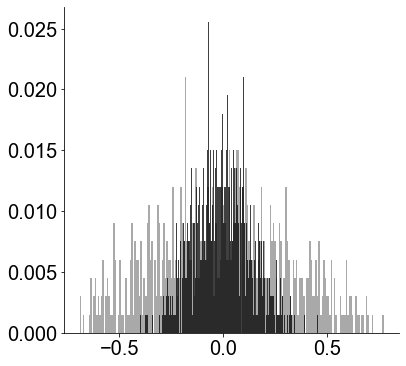

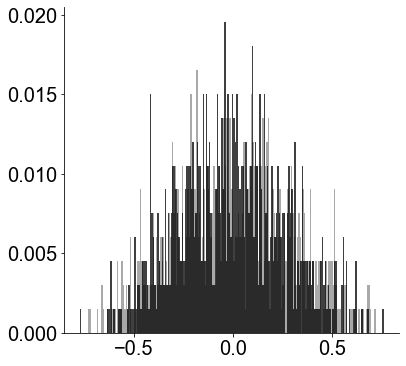

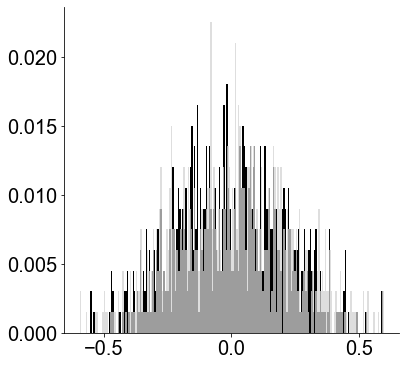

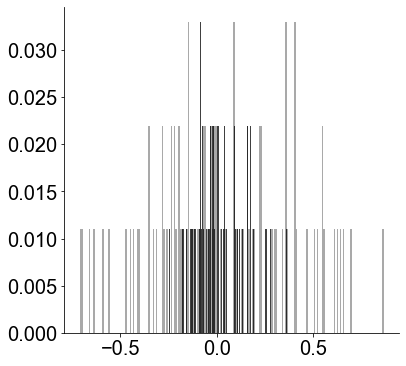

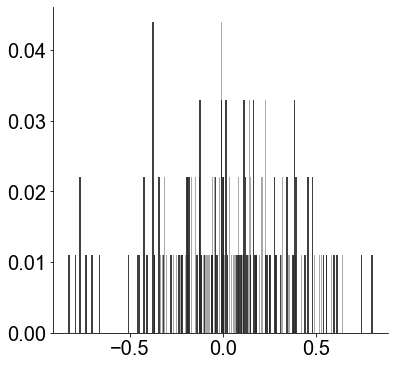

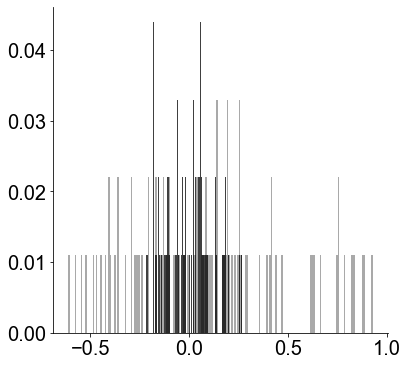

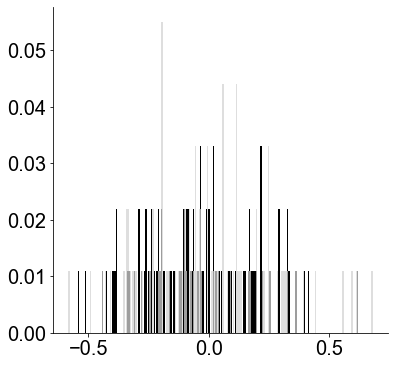

In [20]:
print('WT')

WT_FWHM_list = []

OShchain = []
SShchain = []
OS1chain = []
SS1chain = []
OS2chain = []
SS2chain = []
OS3chain = []
SS3chain = []

WT_sessionhOS_list = []
WT_sessionhSS_list = []
WT_session1OS_list = []
WT_session1SS_list = []
WT_session2OS_list = []
WT_session2SS_list = []
WT_session3OS_list = []
WT_session3SS_list = []

for i in range(len(WT_list)):
    
    mouse_name = WT_list[i]
    
    print('Processing', mouse_name)
    
    mice = os.path.join(root_path, mouse_name)
    trace = os.path.join(root_path, mouse_name, "trace.csv")
    position = os.path.join(root_path, mouse_name, "cells position.csv")
    event0 = os.path.join(root_path, mouse_name, "event0.xlsx")
    event1 = os.path.join(root_path, mouse_name, "event1.xlsx")
    event2 = os.path.join(root_path, mouse_name, "event2.xlsx")
    event3 = os.path.join(root_path, mouse_name, "event3.xlsx")
    incorrect = os.path.join(root_path_incorrect, WT_incorrect_neuron_list[i])
    
    # define fps based on mouse_name
    if mouse_name.split('_')[0] in ['NC128','NC102', 'NC013']:
        fps = 20
    else:
        fps = 15
        
    df = process_(trace, incorrect, position) 
    dfLabeled, session_0, session_1, session_2, session_3 = add_event_label(df, event0, event1, event2, event3, mice)
    
    session_list = [session_0, session_1, session_2, session_3]
    sessionName_list = ['habituation', 'session_1', 'session_2', 'session_3']
    
    for session_index in range(len(sessionName_list)):
        
        session = session_list[session_index]
        sessionName = sessionName_list[session_index]
        
        social_df = check_frame_interval(session, 'social')
        object_df = check_frame_interval(session, 'obj') 
        
        SS_corrs = corr_list(social_df)
        OS_corrs = corr_list(object_df)
        
        # loop and update chain
        if sessionName == 'habituation':
            SShchain = itertools.chain(SShchain,SS_corrs)
            OShchain = itertools.chain(OShchain,OS_corrs)
        elif sessionName == 'session_1':
            SS1chain = itertools.chain(SS1chain,SS_corrs)
            OS1chain = itertools.chain(OS1chain,OS_corrs)
        elif sessionName == 'session_2':
            SS2chain = itertools.chain(SS2chain,SS_corrs)
            OS2chain = itertools.chain(OS2chain,OS_corrs)
        else :
            SS3chain = itertools.chain(SS3chain,SS_corrs)
            OS3chain = itertools.chain(OS3chain,OS_corrs)
        
        # plot each session/mouse
        if len(SS_corrs) != 0 and len(OS_corrs) != 0:
            if sessionName == 'session_3':
                figsize = (6,6)
                title = mouse_name+"_"+sessionName+" OldObjectvsNewSocial"
                overlaid_histogram(figsize,SS_corrs, OS_corrs, n_bins = 200, 
                           data1_name="WT_newSocial", data1_color="black", 
                           data2_name="WT_oldSocial", data2_color="lightgray", 
                           x_label="Correlation", y_label="P", title=title)

            else:
                figsize = (6,6)
                title = mouse_name+"_"+sessionName+" OBJECTvsSOCIAL"
                overlaid_histogram(figsize,OS_corrs, SS_corrs, n_bins = 200, 
                           data1_name="WT_Object", data1_color="darkgray", 
                           data2_name="WT_Social", data2_color="black", 
                           x_label="Correlation", y_label="P", title=title)

        # save FWHM
        FWHM_dic = {'mouseName':mouse_name,
                    'whichSession':sessionName,
                    'object FWHM':FWHM(OS_corrs),
                    'social FWHM':FWHM(SS_corrs)}
        WT_FWHM = pd.DataFrame.from_dict(FWHM_dic, orient='index').T
        WT_FWHM_list.append(WT_FWHM)

        
WT_FWHM_DF = pd.concat(WT_FWHM_list)
WT_FWHM_DF.to_csv('WT_FWHM.csv')

NULL
Processing NC102_Null


C:\Users\xiaoqian10\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\xiaoqian10\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:333: SettingWithCopyWarning:

Processing NC103_Null


C:\Users\xiaoqian10\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\xiaoqian10\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
C:\Users\xiaoqian10\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Processing NC114_Null
Processing NC159_Null
Processing NC227_Null
Processing NC232_Null


C:\Users\xiaoqian10\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Processing NC239_Null


C:\Users\xiaoqian10\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Processing NC296_Null
Processing NC303_Null
Processing NC304_Null
Processing NC313_Null
Processing NC462_Null
Processing NC468_Null
Processing NC475_Null


C:\Users\xiaoqian10\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


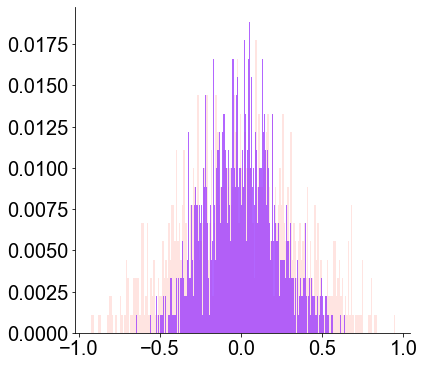

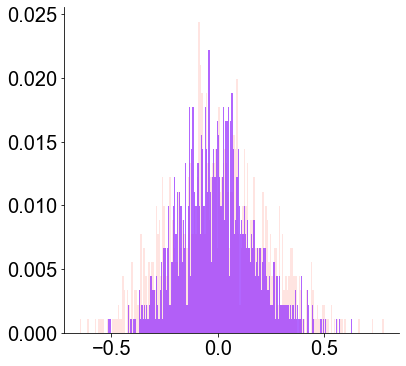

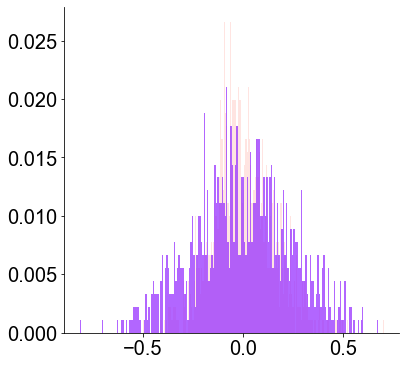

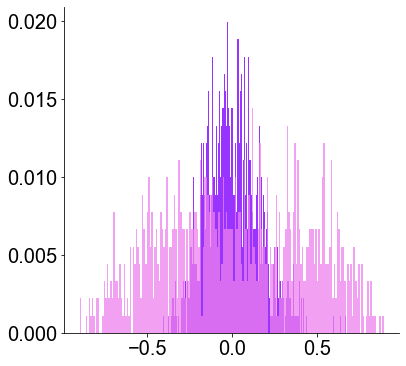

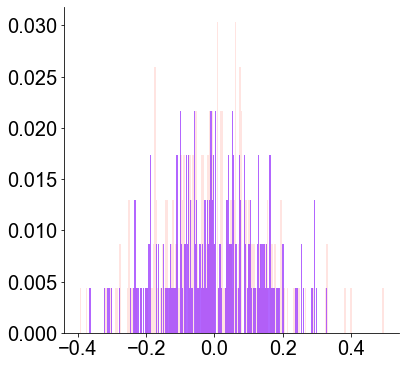

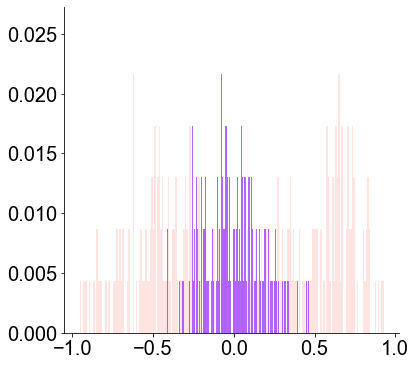

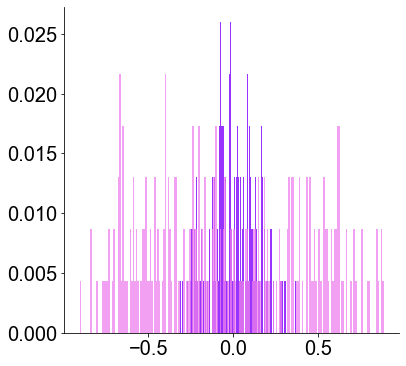

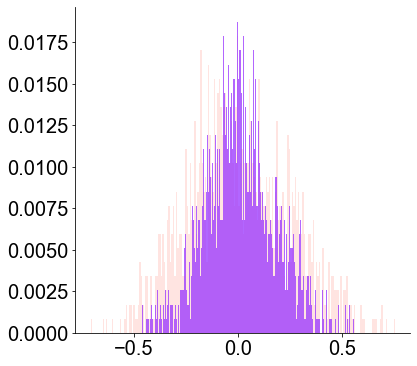

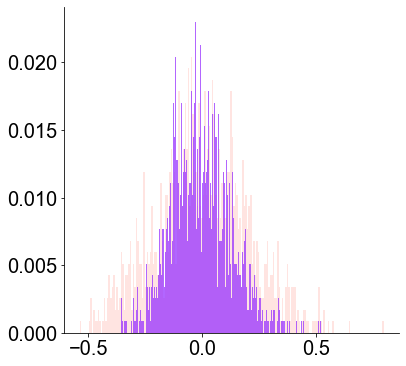

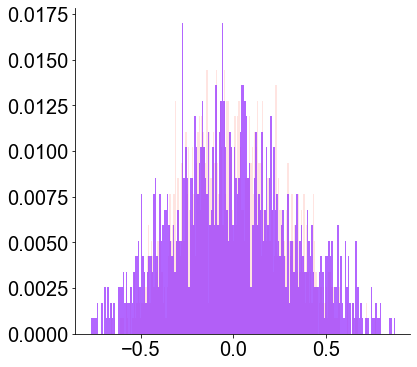

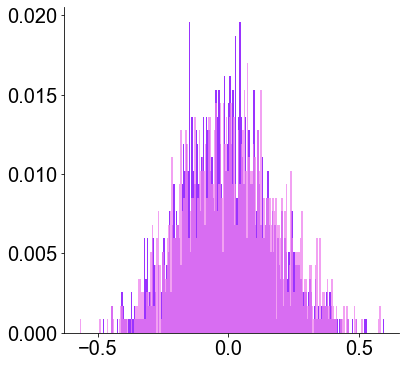

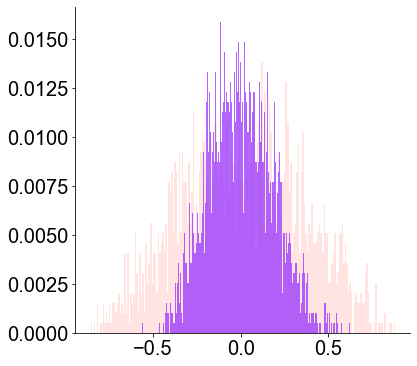

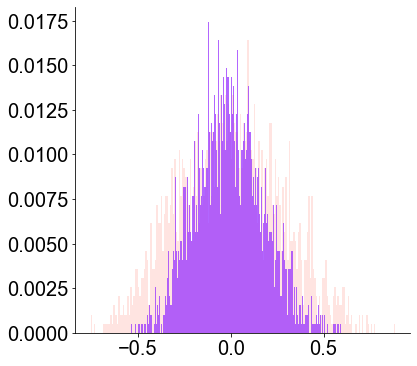

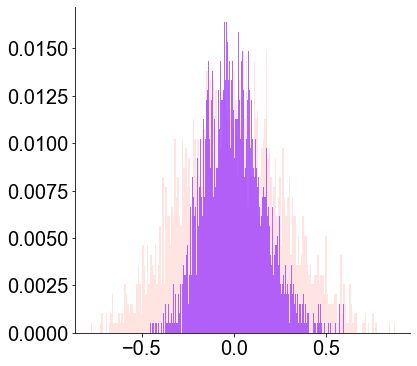

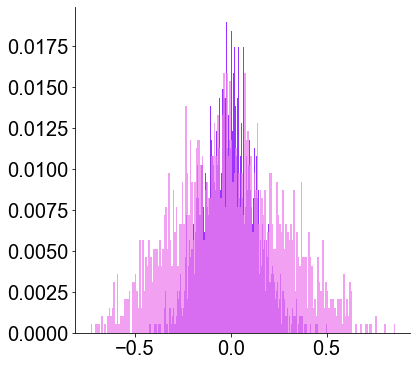

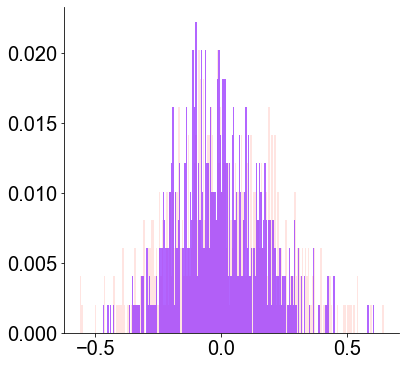

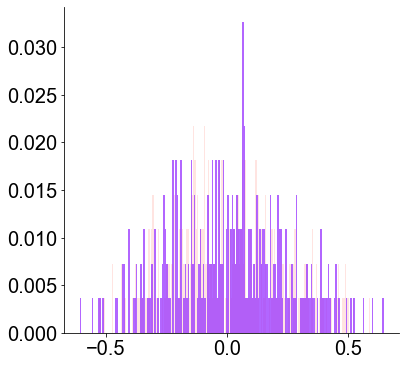

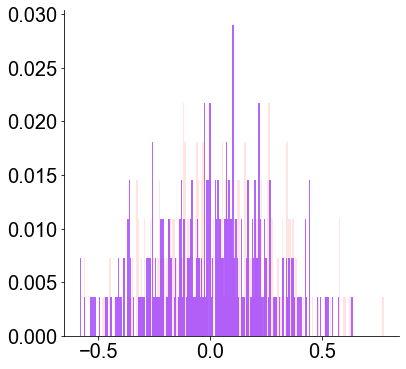

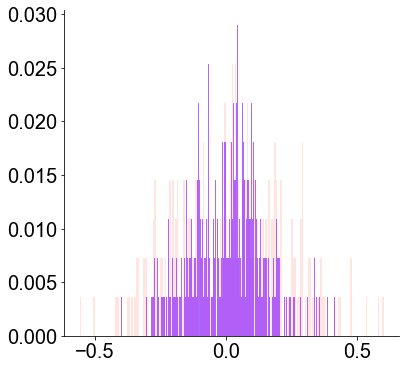

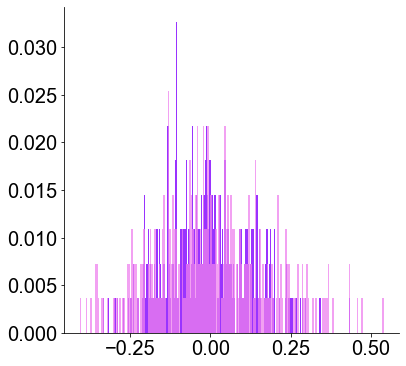

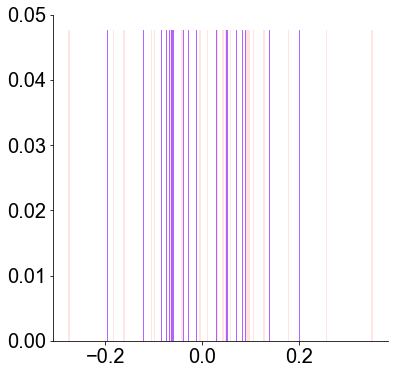

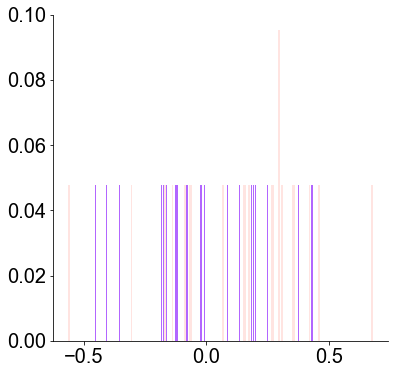

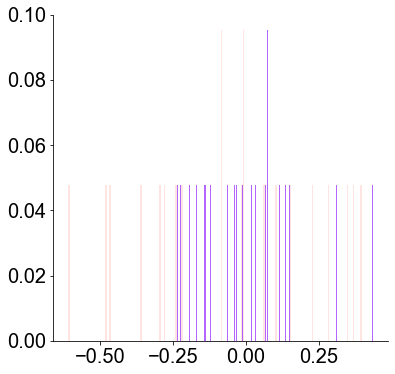

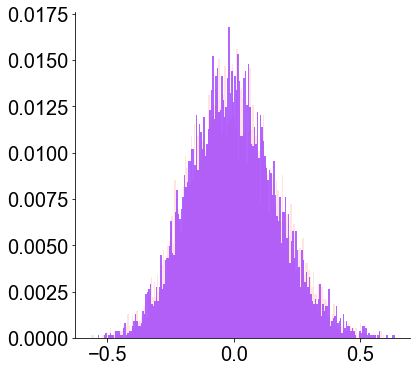

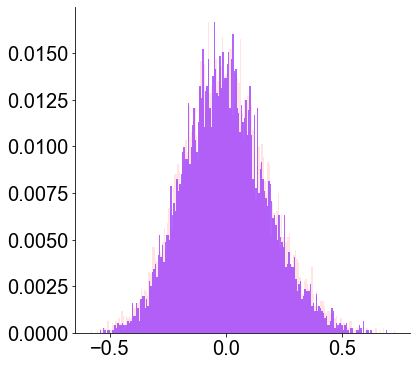

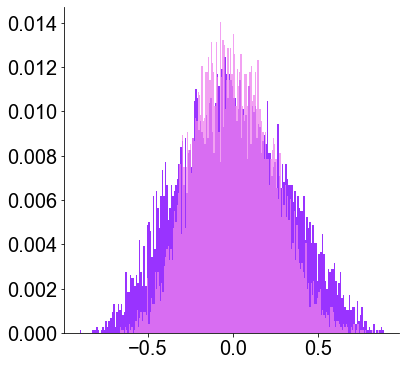

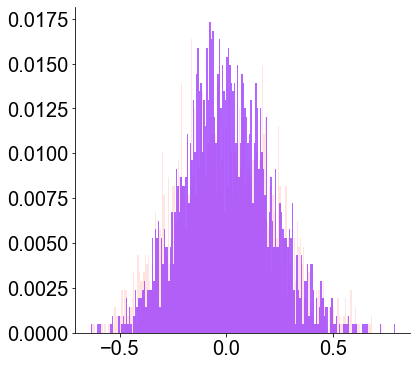

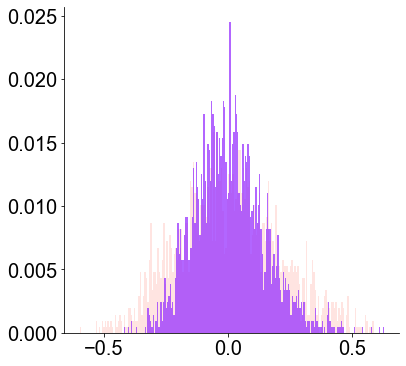

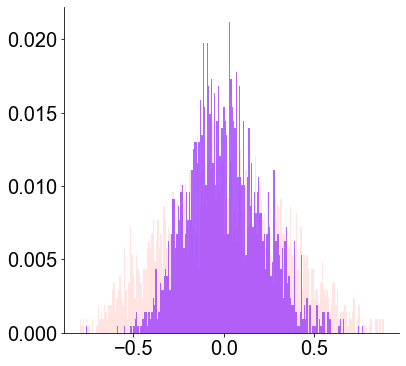

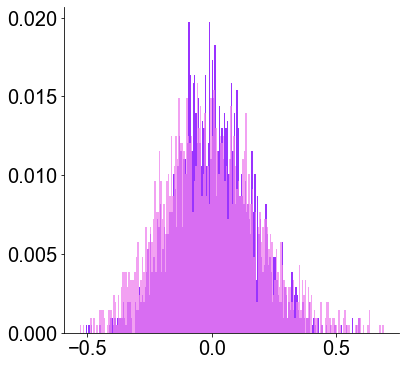

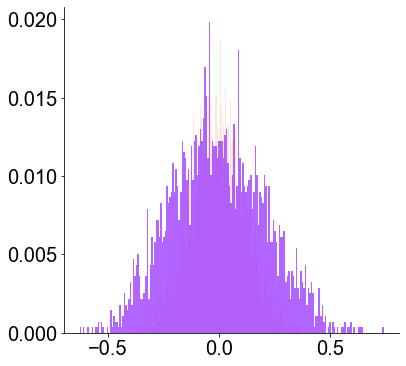

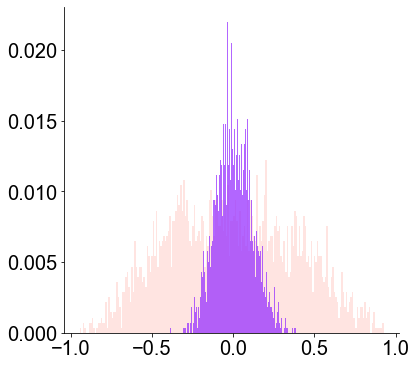

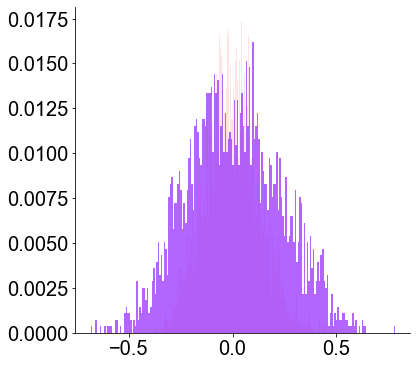

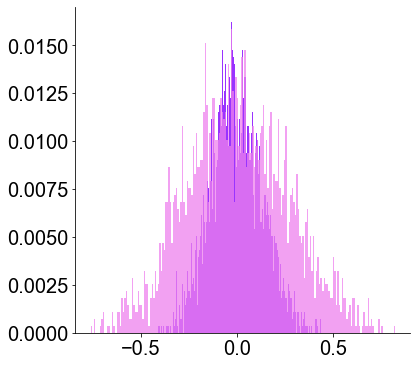

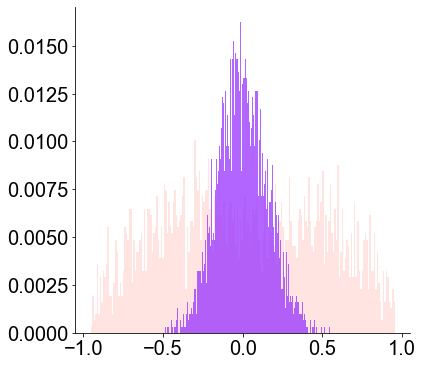

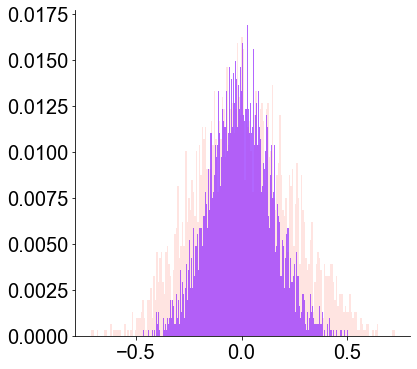

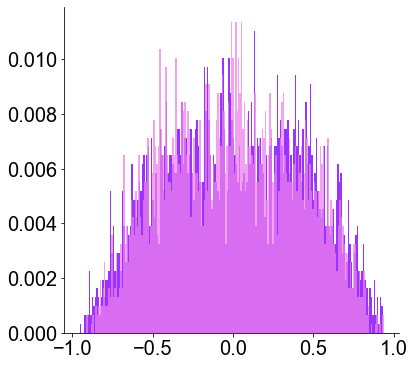

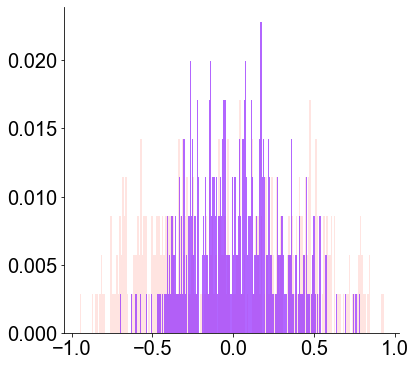

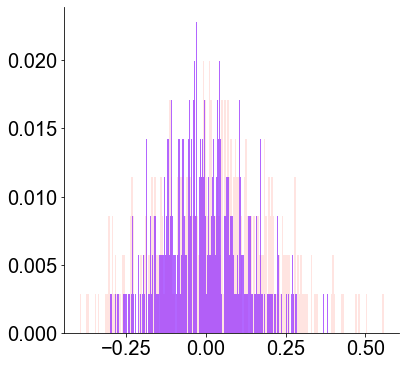

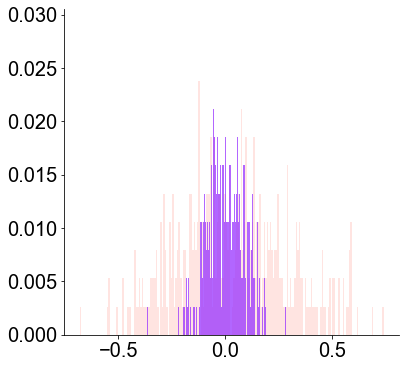

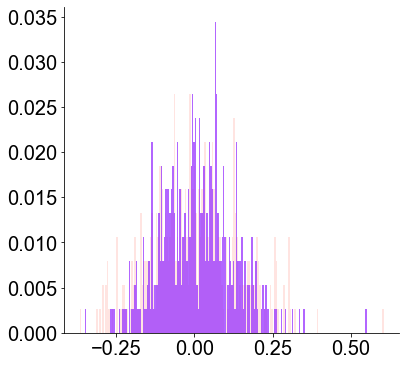

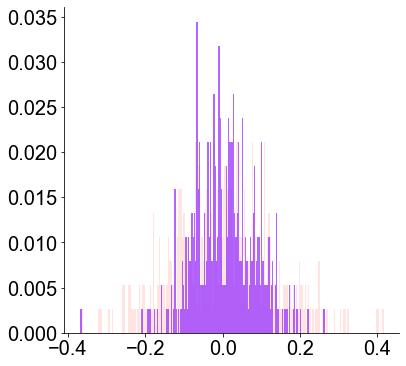

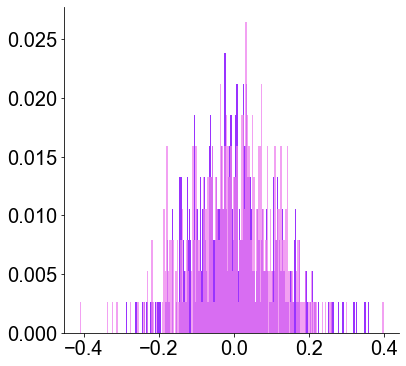

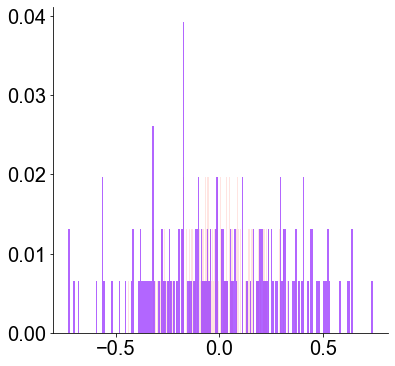

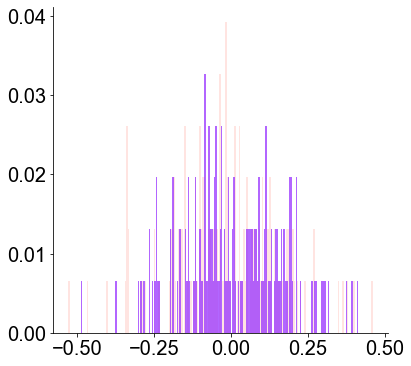

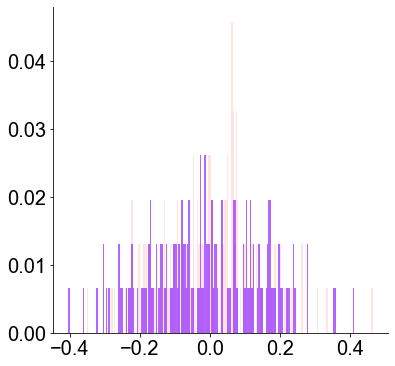

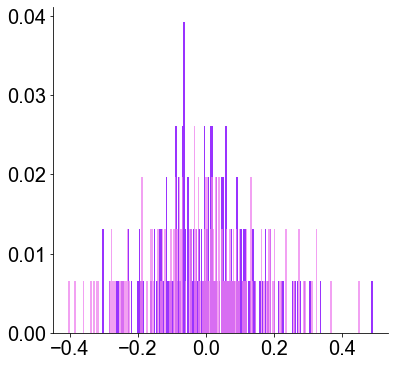

In [9]:
print('NULL')

NULL_FWHM_list = []

OShchain = []
SShchain = []
OS1chain = []
SS1chain = []
OS2chain = []
SS2chain = []
OS3chain = []
SS3chain = []

NULL_sessionhOS_list = []
NULL_sessionhSS_list = []
NULL_session1OS_list = []
NULL_session1SS_list = []
NULL_session2OS_list = []
NULL_session2SS_list = []
NULL_session3OS_list = []
NULL_session3SS_list = []

for i in range(len(NULL_list)):
    
    mouse_name = NULL_list[i]
    
    print('Processing', mouse_name)
    
    mice = os.path.join(root_path, mouse_name)
    trace = os.path.join(root_path, mouse_name, "trace.csv")
    position = os.path.join(root_path, mouse_name, "cells position.csv")
    event0 = os.path.join(root_path, mouse_name, "event0.xlsx")
    event1 = os.path.join(root_path, mouse_name, "event1.xlsx")
    event2 = os.path.join(root_path, mouse_name, "event2.xlsx")
    event3 = os.path.join(root_path, mouse_name, "event3.xlsx")
    incorrect = os.path.join(root_path_incorrect, NULL_incorrect_neuron_list[i])
    
    # define fps based on mouse_name
    if mouse_name.split('_')[0] in ['NC128','NC102', 'NC013']:
        fps = 20
    else:
        fps = 15
        
    df = process_(trace, incorrect, position) 
    dfLabeled, session_0, session_1, session_2, session_3 = add_event_label(df, event0, event1, event2, event3, mice)
    
    session_list = [session_0, session_1, session_2, session_3]
    sessionName_list = ['habituation', 'session_1', 'session_2', 'session_3']
    
    for session_index in range(len(sessionName_list)):
        
        session = session_list[session_index]
        sessionName = sessionName_list[session_index]
        
        social_df = check_frame_interval(session, 'social')
        object_df = check_frame_interval(session, 'obj') 
        
        SS_corrs = corr_list(social_df)
        OS_corrs = corr_list(object_df)
        
        # loop and update chain
        if sessionName == 'habituation':
            SShchain = itertools.chain(SShchain,SS_corrs)
            OShchain = itertools.chain(OShchain,OS_corrs)
        elif sessionName == 'session_1':
            SS1chain = itertools.chain(SS1chain,SS_corrs)
            OS1chain = itertools.chain(OS1chain,OS_corrs)
        elif sessionName == 'session_2':
            SS2chain = itertools.chain(SS2chain,SS_corrs)
            OS2chain = itertools.chain(OS2chain,OS_corrs)
        else:
            SS3chain = itertools.chain(SS3chain,SS_corrs)
            OS3chain = itertools.chain(OS3chain,OS_corrs)
        
        # plot each session/mouse
        if len(SS_corrs) != 0 and len(OS_corrs) != 0:
            if sessionName == 'session_3':
                figsize = (6,6)
                title = mouse_name+"_"+sessionName+" OldObjectvsNewSocial"
                overlaid_histogram(figsize,SS_corrs, OS_corrs, n_bins = 200, 
                           data1_name="NULL_newSocial", data1_color="#9933ff", 
                           data2_name="NULL_oldSocial", data2_color="violet", 
                           x_label="Correlation", y_label="P", title=title)

            else:
                figsize = (6,6)
                title = mouse_name+"_"+sessionName+" OBJECTvsSOCIAL"
                overlaid_histogram(figsize,OS_corrs, SS_corrs, n_bins = 200, 
                           data1_name="NULL_Object", data1_color="mistyrose", 
                           data2_name="NULL_Social", data2_color="#9933ff", 
                           x_label="Correlation", y_label="P", title=title)

        # save FWHM
        FWHM_dic = {'mouseName':mouse_name,
                    'whichSession':sessionName,
                    'object FWHM':FWHM(OS_corrs),
                    'social FWHM':FWHM(SS_corrs)}
        NULL_FWHM = pd.DataFrame.from_dict(FWHM_dic, orient='index').T
        NULL_FWHM_list.append(NULL_FWHM)

        
NULL_FWHM_DF = pd.concat(NULL_FWHM_list)
NULL_FWHM_DF.to_csv('NULL_FWHM.csv')

# Call

- all mice

In [ ]:
WT_sessionhOS_list = list(OShchain)
WT_sessionhSS_list = list(SShchain)
WT_session1OS_list = list(OS1chain)
WT_session1SS_list = list(SS1chain)
WT_session2OS_list = list(OS2chain)
WT_session2SS_list = list(SS2chain)
WT_session3OS_list = list(OS3chain)
WT_session3SS_list = list(SS3chain)

figsize = (6,6)
overlaid_histogram(figsize,WT_sessionhOS_list, WT_sessionhSS_list, n_bins = 200, 
                   data1_name="WT_Object", data1_color="darkgray", 
                   data2_name="WT_Social", data2_color="black", 
                   x_label="Pearson Correlation Coefficient Distribution", y_label="Probability",
                   title="habituation WT OBJECTvsSOCIAL")

overlaid_histogram(figsize,WT_session1OS_list, WT_session1SS_list, n_bins = 200, 
                   data1_name="WT_Object", data1_color="darkgray", 
                   data2_name="WT_Social", data2_color="black", 
                   x_label="Pearson Correlation Coefficient Distribution", y_label="Probability",
                   title="session 1 WT OBJECTvsSOCIAL")

overlaid_histogram(figsize,WT_session2OS_list, WT_session2SS_list, n_bins = 200, 
                   data1_name="WT_Object", data1_color="darkgray", 
                   data2_name="WT_Social", data2_color="black", 
                   x_label="Pearson Correlation Coefficient Distribution", y_label="Probability",
                   title="session 2 WT OBJECTvsSOCIAL")

overlaid_histogram(figsize,WT_session3SS_list, WT_session3OS_list, n_bins = 200, 
                   data1_name="WT_newSocial", data1_color="black", 
                   data2_name="WT_oldSocial", data2_color="lightgrey", 
                   x_label="Pearson Correlation Coefficient Distribution", y_label="Probability",
                   title="session 3 WT OldObjectvsNewSocial")


allFWHM_dic = {'mouseType':'WT',
            'whichSession':'habituation',
            'object FWHM':FWHM(WT_sessionhOS_list),
            'social FWHM':FWHM(WT_sessionhSS_list),
            'whichSession':'session 1',
            'object FWHM':FWHM(WT_session1OS_list),
            'social FWHM':FWHM(WT_session1SS_list),
            'whichSession':'session 2',
            'object FWHM':FWHM(WT_session2OS_list),
            'social FWHM':FWHM(WT_session2SS_list),
            'whichSession':'session 3',
            'object FWHM':FWHM(WT_session3OS_list),
            'social FWHM':FWHM(WT_session3SS_list)}
WT_FWHM_All = pd.DataFrame.from_dict(allFWHM_dic, orient='index').T
WT_FWHM_All.to_csv('WT_FWHM_All.csv')

In [ ]:
NULL_sessionhOS_list = list(OShchain)
NULL_sessionhSS_list = list(SShchain)
NULL_session1OS_list = list(OS1chain)
NULL_session1SS_list = list(SS1chain)
NULL_session2OS_list = list(OS2chain)
NULL_session2SS_list = list(SS2chain)
NULL_session3OS_list = list(OS3chain)
NULL_session3SS_list = list(SS3chain)

figsize = (6,6)
overlaid_histogram(figsize,NULL_sessionhOS_list, NULL_sessionhSS_list, n_bins = 200, 
                   data1_name="NULL_Object", data1_color="mistyrose", 
                   data2_name="NULL_Social", data2_color="#9933ff", 
                   x_label="Pearson Correlation Coefficient Distribution", y_label="Probability",
                   title="habituation NULL OBJECTvsSOCIAL")

overlaid_histogram(figsize,NULL_session1OS_list, NULL_session1SS_list, n_bins = 200, 
                   data1_name="NULL_Object", data1_color="mistyrose", 
                   data2_name="NULL_Social", data2_color="#9933ff", 
                   x_label="Pearson Correlation Coefficient Distribution", y_label="Probability",
                   title="session 1 NULL OBJECTvsSOCIAL")

overlaid_histogram(figsize,NULL_session2OS_list, NULL_session2SS_list, n_bins = 200, 
                   data1_name="NULL_Object", data1_color="mistyrose", 
                   data2_name="NULL_Social", data2_color="#9933ff", 
                   x_label="Pearson Correlation Coefficient Distribution", y_label="Probability",
                   title="session 2 NULL OBJECTvsSOCIAL")

overlaid_histogram(figsize,NULL_session3SS_list, NULL_session3OS_list, n_bins = 200, 
                   data1_name="NULL_newSocial", data1_color="#9933ff", 
                   data2_name="NULL_oldSocial", data2_color="violet", 
                   x_label="Pearson Correlation Coefficient Distribution", y_label="Probability",
                   title="session 3 NULL OldObjectvsNewSocial")

allFWHM_dic = {'mouseType':'NULL',
            'whichSession':'habituation',
            'object FWHM':FWHM(NULL_sessionhOS_list),
            'social FWHM':FWHM(NULL_sessionhSS_list),
            'whichSession':'session 1',
            'object FWHM':FWHM(NULL_session1OS_list),
            'social FWHM':FWHM(NULL_session1SS_list),
            'whichSession':'session 2',
            'object FWHM':FWHM(NULL_session2OS_list),
            'social FWHM':FWHM(NULL_session2SS_list),
            'whichSession':'session 3',
            'object FWHM':FWHM(NULL_session3OS_list),
            'social FWHM':FWHM(NULL_session3SS_list)}
NULL_FWHM_All = pd.DataFrame.from_dict(allFWHM_dic, orient='index').T
NULL_FWHM_All.to_csv('NULL_FWHM_All.csv')